## Graph Analysis

In [36]:

import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pylab as plt
import seaborn as sns
import os
import gensim
import umap

### Loading in the data

In [110]:
# Load in the link data
links_2009 = pd.read_csv('./wikispeedia_paths-and-graph/links.tsv', delim_whitespace=True, names=['from', 'to'], comment='#')
links_2022 = pd.read_csv('./wikispeedia_paths-and-graph/links22.tsv', delim_whitespace=True, comment='#')

# Load in the path data of finished games
wikispeedia_paths = pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv', delim_whitespace=True,\
    names=['hashed_ip', 'timestamp', 'duration_sec', 'path', 'rating'], comment='#')

wikispeedia_paths.head()

### Constructing the graphs

In [40]:
# Construct the directed graph for 2009 by adding all links as edges
graph_2009 = nx.DiGraph()

for l, r in links_2009.iterrows():
    graph_2009.add_edge(r['from'], r['to'])

print(f"The graph from 2009 has {graph_2009.number_of_nodes()} nodes and {graph_2009.number_of_edges()} edges")

The graph from 2009 has 4592 nodes and 119882 edges


In [41]:
# Construct the directed graph for 2022 by adding all links as edges
graph_2022 = nx.DiGraph()

for l, r in links_2022.iterrows():
    graph_2022.add_edge(r['linkSource'], r['linkTarget'])

print(f"The graph from 2022 has {graph_2022.number_of_nodes()} nodes and {graph_2022.number_of_edges()} edges")

The graph from 2022 has 4593 nodes and 227580 edges


While the previous two graphs are unweighted, we choose here to construct a weighted graph for the wikispeedia path graph. We opt to do this as it is more inline the idea of certain links having more importance following "human intuition". Specifically, the weight of each edge is the number of wikispeedia paths that pass through it.

Currently we only add edges from finished paths. We will look into potentially adding unfinished paths as well.

In [42]:
graph_wikispeedia_paths = nx.DiGraph()

for l, r in wikispeedia_paths.iterrows():
    path = r['path'].split(';')
    for i in range(len(path)-1):
        # If the edge already exists, increment the weight.
        if graph_wikispeedia_paths.has_edge(path[i], path[i+1]):
            graph_wikispeedia_paths[path[i]][path[i+1]]['weight'] += 1
        else:
            graph_wikispeedia_paths.add_edge(path[i], path[i+1], weight=1)

print(f"The graph constructed from the finished paths has {graph_wikispeedia_paths.number_of_nodes()}"
      f" nodes and {graph_wikispeedia_paths.number_of_edges()} edges")

The graph constructed from the finished paths has 4170 nodes and 55147 edges


### Creating the node embeddings with node2vec
The embeddings created here serve as a starting point for further qualitative and quantitative analysis. The hyperparameters chosen are done so according to only a small bit of testing. More specifically, the parameters that we might change are the number of embedding dimension $d=128$, the random walk length, and the number of walks. Walk length has tentatively been set to 10 as it is slightly more than wikispeedia path lengths, and seems to yield good clustering in the subsequent embedding graphs.

In [121]:
def get_embedding_model(path, graph):
    """ 
    Attempts to load model from path if model exists, otherwise trains one
    annew using `graph` and saves it.
    """

    if os.path.isfile(path):
        model = gensim.models.word2vec.Word2Vec.load(path)
    else:
        n2v = Node2Vec(graph, dimensions=128, walk_length=10, num_walks=2000, workers=8)
        model = n2v.fit()
        model.save(path)

MODEL_PATH_2009 = './models/n2v_2009.model'
MODEL_PATH_2022 = './models/n2v_2022.model'
MODEL_PATH_WIKISPEEDIA_PATHS = './models/n2v_wikispeedia_paths.model'

In [122]:
# Get all the embeddings for the analysis
model_2009 = get_embedding_model(MODEL_PATH_2009, graph_2009)
model_2022 = get_embedding_model(MODEL_PATH_2022, graph_2022)
model_wikispeedia_paths = get_embedding_model(MODEL_PATH_WIKISPEEDIA_PATHS, graph_wikispeedia_paths)

### Visualizing the embeddings in low-dimensional space with UMAP
#### Visualizing according to categories

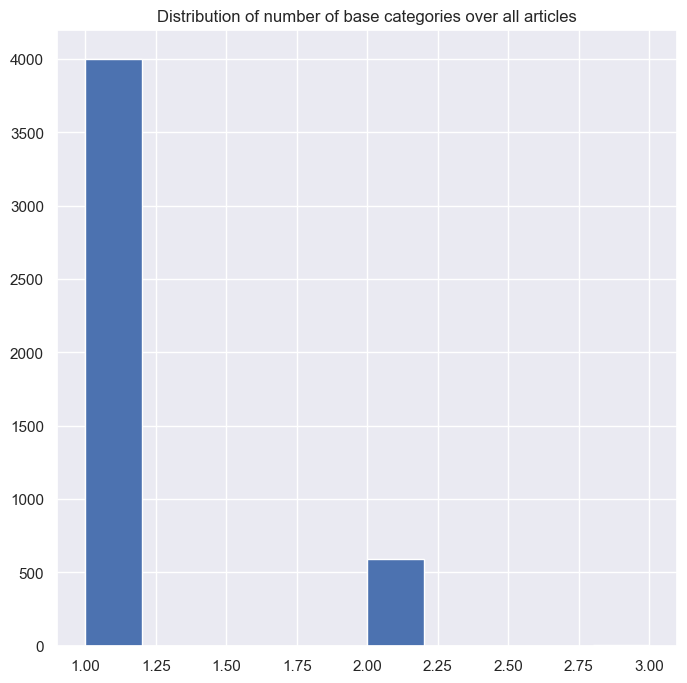

In [125]:
# Read in the categories for each article and extract the highest level category.
# I.e. Science if the category is subject.Science.Chemistry
wiki_2009_categories = pd.read_csv('./wikispeedia_paths-and-graph/categories.tsv', delim_whitespace=True, \
    names=['article', 'category'], comment='#')
wiki_2009_categories.groupby('article').count().hist()
plt.title('Distribution of number of base categories over all articles')

# When articles have more than one main category, we choose to sample one.
# This is perhaps not an optimal method, but it is currently the best we can think of.
wiki_2009_categories = wiki_2009_categories.groupby('article').sample(1)
wiki_2009_categories['category'] = wiki_2009_categories['category'].str.extract(r'subject\.([a-zA-Z]*)')
wiki_2009_categories = wiki_2009_categories.set_index('article')
article_cat = wiki_2009_categories.to_dict()['category']

Here we can see that a not insignificant minority of articles have two main categories, so we may have to deal with this in a better way in the future.

In [113]:
# Helper function for finding the correct categories for each embedding
# in the node2vec models.
def map_categories(model, article_2_cat):
    cat = []
    for k in model.wv.key_to_index.keys():
        if k in article_2_cat:
            cat.append(article_2_cat[k])
        else:
            cat.append("NA")

    return cat

# Helper function for plotting neat embedding graphs.
def plot_embedding(embedding, cat, title):
    palette = {k:v for (k, v) in zip(set(cat), sns.color_palette('tab20'))}
    sns.set(rc={'figure.figsize':(8,8)})
    ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], size=1, data=pd.DataFrame({'category':cat}), hue='category', palette=palette)
    handles, labels = plt.gca().get_legend_handles_labels()
    tmp = sorted(list(zip(handles, labels)), key=lambda x: x[1])[1:]
    plt.legend([x[0] for x in tmp],[x[1] for x in tmp])
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [ ]:
# Use UMAP to find an appropriate low-dim projection
reducer = umap.UMAP()
embedding_2009 = reducer.fit_transform(model_2009.wv.get_normed_vectors())

reducer = umap.UMAP()
embedding_2022 = reducer.fit_transform(model_2022.wv.get_normed_vectors())

reducer = umap.UMAP()
embedding_wikispeedia_paths = reducer.fit_transform(model_wikispeedia_paths.wv.get_normed_vectors())

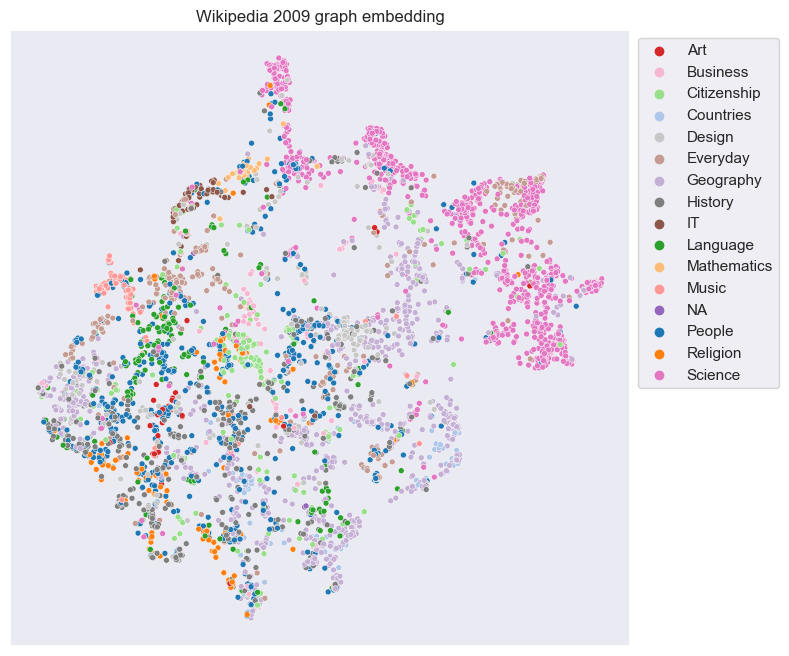

In [114]:
cat = map_categories(model_2009, article_cat)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embedding')

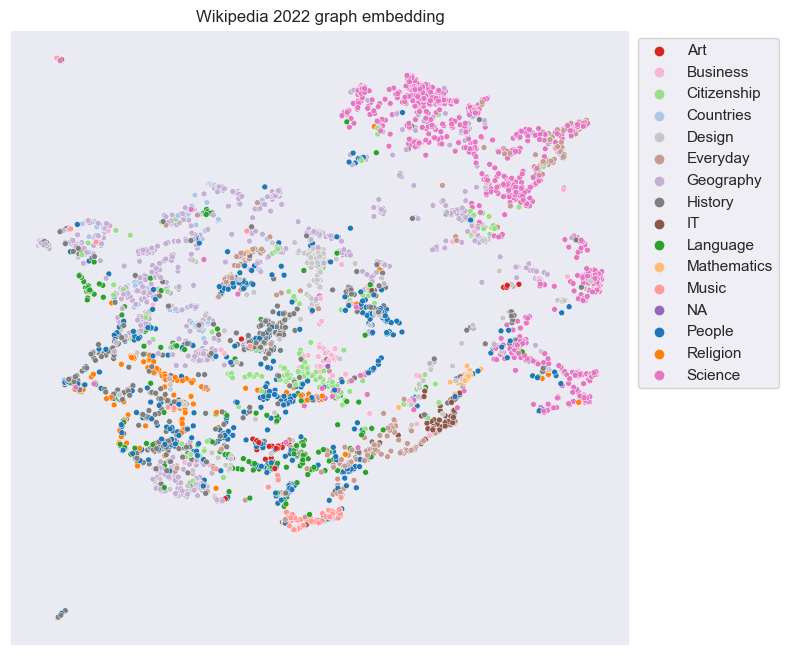

In [115]:
cat = map_categories(model_2022, article_cat)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embedding')

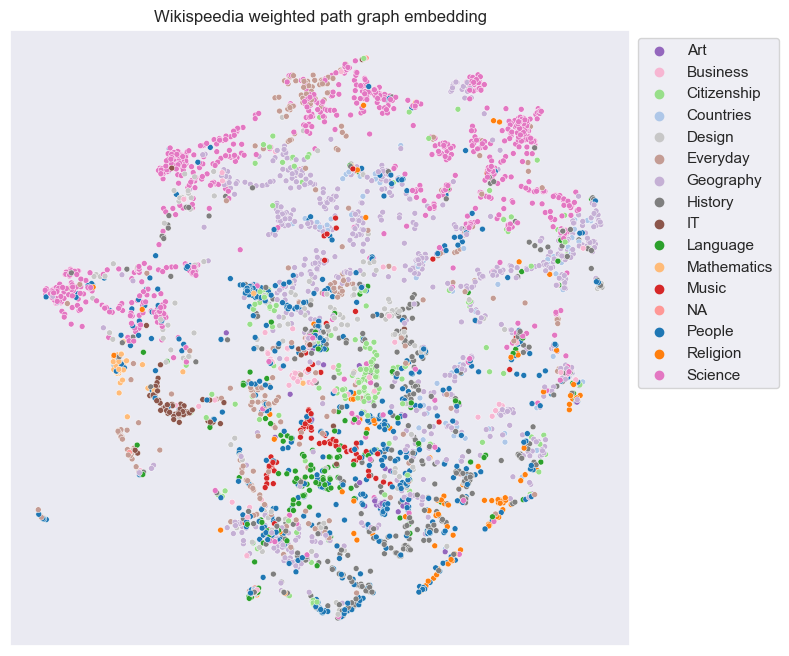

In [116]:
cat = map_categories(model_wikispeedia_paths, article_cat)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embedding')

**Analysis:**
Comparing the three graphs we can see that there are some really interesting category clusterings. Science seems to be a very large part of the corpus for example. We can also see that the Mathematics and IT clusters end up close to each other, nearby the one end of the science cluster. Looking closer at the differences between wikispeedia and the other two we can see that from visual analysis, the wikispeedia graph exibits less tight local clustering with some categories fragmented to a larger extent. Specifically, we observe that some categories like Science, IT continue to be relatively tightly linked, while others that are more general such as Geography and Countries are more scattered.

#### Visualizing according to hub and authority categorization
In this part we use the HITS algorithm to figure out if articles are hubs or authorities. An article that is a hub is one that has many outgoing links to authorities, and an article that is an authority has many incoming links from hubs. We choose here to not modify any of the hyperparameters of the HITS algorithm and leave them at their library defaults. Specifically, we here classify an article as a hub if it has a higher hub-score and vice versa.

In [99]:
def hits_categorize(graph):
    graph_hits = nx.hits(graph)

    graph_2_hits_cat = {}
    for (k1, v1), (k2, v2) in zip(graph_hits[0].items(), graph_hits[1].items()):
        if v1 > v2:
            graph_2_hits_cat[k1] = 'hub'
        else:
            graph_2_hits_cat[k1] = 'authority'
    
    return graph_2_hits_cat


/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


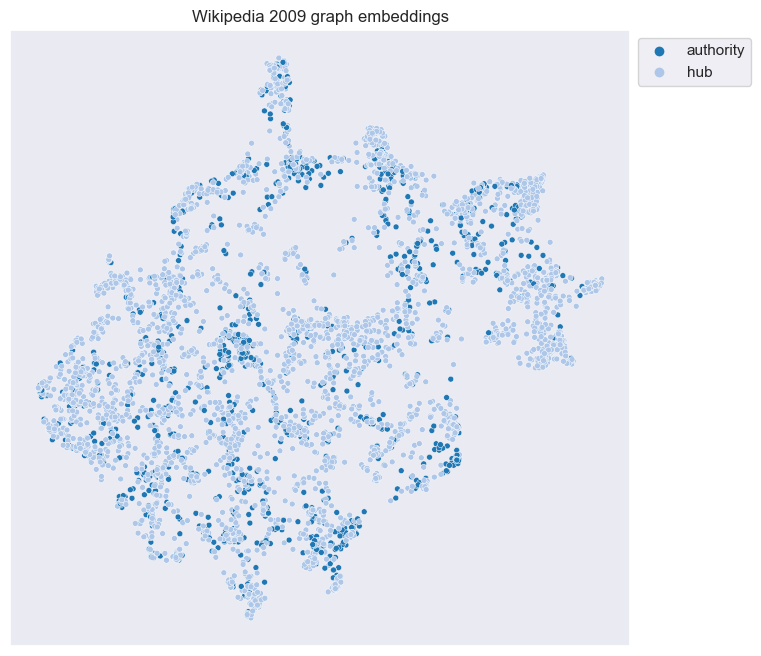

In [117]:
wiki_2009_2_hits = hits_categorize(graph_2009)
cat = map_categories(model_2009, wiki_2009_2_hits)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


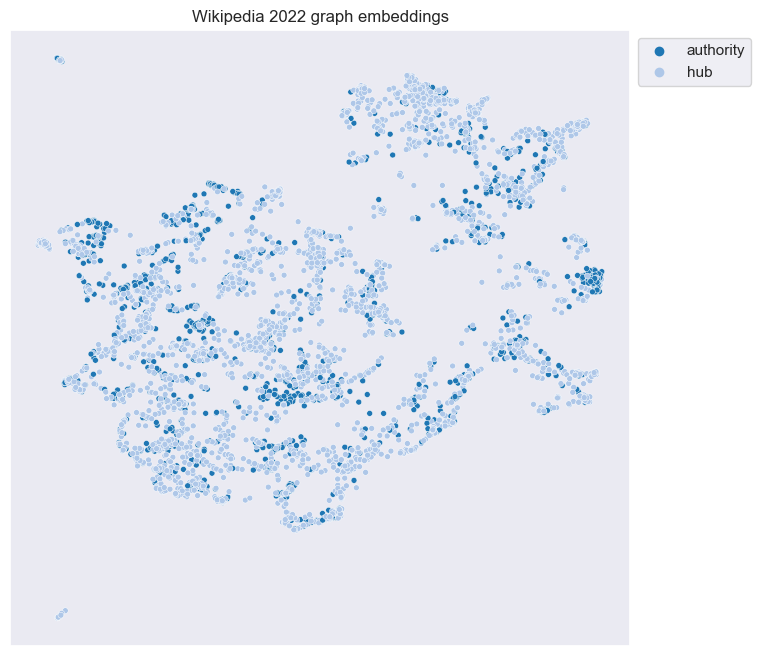

In [118]:
wiki_2022_2_hits = hits_categorize(graph_2022)
cat = map_categories(model_2022, wiki_2022_2_hits)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


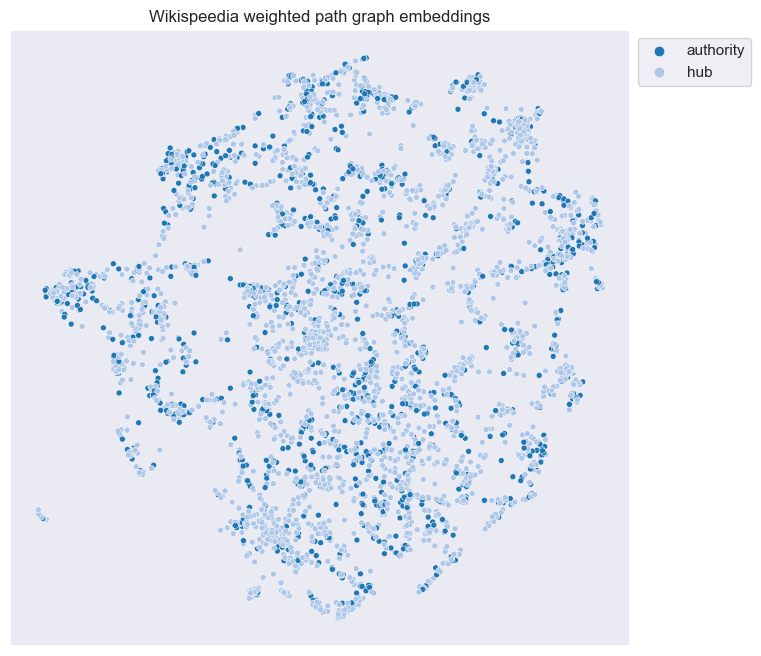

In [119]:
wikispeedia_2_hits = hits_categorize(graph_wikispeedia_paths)
cat = map_categories(model_wikispeedia_paths, wikispeedia_2_hits)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embeddings')

**Analysis:**
A tentative qualitative analysis shows that the embedding projections generated from the actual 2009 and 2022 graphs exhibit more a clustering behaviour in the authority articles as opposed to in the graph generated from the wikispeedia paths. 